In [1]:
# Standard library imports
import os
import random
import gc
import copy

# Third-party library imports
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 12.1
cuDNN Version: 90100
PyTorch Version: 2.5.1+cu121
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA A100-PCIE-40GB MIG 7g.40gb
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [4]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Create variable to store dataset name
dataset_name = 'california_housing'
results_path = f'logs/Regression/{dataset_name}/ViT+MLP_Regression'

In [6]:
df = pd.read_csv(f"Datasets/Regression/{dataset_name}.csv")

In [7]:
df.shape

(20640, 9)

In [8]:
# Drop the second-to-last column if MIMO
# df = df.drop(df.columns[-1], axis=1)

In [9]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## LOAD AND PREPROCESS

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]
    
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [30]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return x

In [31]:
def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:  # Check to include both divisors if they are not the same
                divisors.append(n // i)
    divisors.sort()
    return divisors

In [32]:
# Intermediate Fusion by concatenation
# Process independently each modaility and combines their embeddings. 
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model1, self).__init__()
        
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape[1],
            patch_size = patch_size,
            dim = 128,
            depth = 4,
            heads = 8,
            mlp_dim = 256
        )

        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128+16, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        vit_output = self.vit(vit_input)
        mlp_output = self.mlp(mlp_input)
        concat_output = torch.cat((mlp_output, vit_output), dim=1)
        return self.final_mlp(concat_output)

In [33]:
# Intermediate Fusion by gating mechanism (static gating)
# Static Gating module that learns to emphasize or suppress each modality. 
# The gating weights are learnable parameters but remains the same for every sample.

class StaticGating(nn.Module):
    def __init__(self, num_features, img_features):
        super(StaticGating, self).__init__()
        
        # Static learnable weights
        self.num_gate = nn.Parameter(torch.tensor(0.5))
        self.img_gate = nn.Parameter(torch.tensor(0.5))
        
        self.final_fc = nn.Linear(128, 128)

    def forward(self, num_data, img_data):
        
        # Apply static gating
        gated_output = self.num_gate * num_data + self.img_gate * img_data
        return self.final_fc(gated_output)

    
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model2, self).__init__()
        
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape[1],
            patch_size = patch_size,
            dim = 128,
            depth = 4,
            heads = 8,
            mlp_dim = 256
        )

        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Gating Module
        self.gating = StaticGating(num_features=16, img_features=128)
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Pass through MLP branch
        mlp_output = self.mlp(mlp_input)
        
        # Pass through ViT branch
        vit_output = self.vit(vit_input)
        
        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Apply gating mechanism
        gated_output = self.gating(mlp_output, vit_output)
        
        # Pass through final MLP
        return self.final_mlp(gated_output)

In [34]:
# Intermediate Fusion by attention mechanism (dynamic gating)
# Attention module that learns to emphasize or suppress each modality.
# The attention weights changes based on input data. Limited to global weighting.

class MultiheadAttentionGating(nn.Module):
    def __init__(self, num_features, img_features):
        super(MultiheadAttentionGating, self).__init__()
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Two attention scores (one for each modality)
            nn.Softmax(dim=1)
        )

    def forward(self, num_data, img_data):

        # Concatenate transformed features
        concat_data = torch.cat((num_data, img_data), dim=1)
        
        # Compute attention weights
        attention_weights = self.attention(concat_data)  # Output: [batch_size, 2]
        num_weight = attention_weights[:, 0].unsqueeze(1)  # Shape: [batch_size, 1]
        img_weight = attention_weights[:, 1].unsqueeze(1)  # Shape: [batch_size, 1]
        
        # Weighted sum of modalities
        return num_weight * num_data + img_weight * img_data



class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model3, self).__init__()
        
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape[1],
            patch_size = patch_size,
            dim = 128,
            depth = 4,
            heads = 8,
            mlp_dim = 256
        )

        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Gating mechanism for fusion
        self.gating = MultiheadAttentionGating(num_features=16, img_features=128)
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        vit_output = self.vit(vit_input)
        mlp_output = self.mlp(mlp_input)

        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Apply gating mechanism to fuse outputs
        fused_output = self.gating(mlp_output, vit_output)  # Output: [batch_size, 128]

        # Final prediction through MLP
        return self.final_mlp(fused_output)  # Output: [batch_size, 1]

In [35]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# Attention module that learns to emphasize or suppress each modality.
# Instead of commputing the weight based on a concatenation of the modalities, we compute the pairwise interaction between the two modalities.
# The attention weights changes based on input data.
# Use mean pooling, averages embeddings after attention. Simple tasks with balanced modality contributions.

class MultiheadAttentionGatingWithMean(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiheadAttentionGatingWithMean, self).__init__()
        
        # Multihead attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        
        # Output linear layer for refining the fused representation
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, num_data, img_data):
        # Add a sequence dimension to the MLP and ViT outputs
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, seq_len=1, embed_dim)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, seq_len=1, embed_dim)

        # Concatenate the numeric and image data along the sequence dimension
        combined_data = torch.cat((num_data, img_data), dim=1)  # Shape: (batch_size, seq_len=2, embed_dim)

        # Apply multihead attention to the combined data
        attn_output, _ = self.multihead_attn(query=combined_data, key=combined_data, value=combined_data)

        # Perform mean pooling to reduce the sequence dimension to a single fused representation
        fused_output = attn_output.mean(dim=1)  # Shape: (batch_size, embed_dim)

        # Refine the fused representation through a linear layer
        return self.output_layer(fused_output)

class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model4, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )
        
        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Multihead attention module for intermediate fusion
        self.attention_fusion = MultiheadAttentionGatingWithMean(embed_dim=128, num_heads=4)

        # Final MLP for prediction
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),  # First layer to reduce dimensionality
            nn.ReLU(),
            nn.Linear(64, 32),   # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),   # Third layer
            nn.ReLU(),
            nn.Linear(16, 1)     # Final layer for output
        )

    def forward(self, mlp_input, vit_input):
        # Pass the tabular data through the MLP branch
        mlp_output = self.mlp(mlp_input)  # Output shape: (batch_size, 16)
        
        # Pass the image data through the ViT branch
        vit_output = self.vit(vit_input)  # Output shape: (batch_size, 128)

        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)

        # Fuse the outputs using multihead attention with mean pooling
        fused_output = self.attention_fusion(mlp_output, vit_output)  # Shape: (batch_size, 128)

        # Pass the fused representation through the final MLP for prediction
        return self.final_mlp(fused_output)  # Final output shape: (batch_size, 1)


In [36]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# Attention module that learns to emphasize or suppress each modality.
# Instead of commputing the weight based on a concatenation of the modalities, we compute the pairwise interaction between the two modalities.
# The attention weights changes based on input data.
# Use CLS, uses a learnable token to summarize fusion. Tasks requiring adaptive fusion across modalities.

class AttentionGatingWithCLS(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(AttentionGatingWithCLS, self).__init__()
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable CLS token
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, num_data, img_data):
        
        # Add sequence dimension to MLP and ViT outputs
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Prepend CLS token
        cls_token = self.cls_token.expand(num_data.size(0), -1, -1)  # (batch_size, 1, embed_dim)
        combined_data = torch.cat((cls_token, num_data, img_data), dim=1)  # (batch_size, seq_len=3, embed_dim)

        # Apply multi-head attention
        attn_output, _ = self.multihead_attn(query=combined_data, key=combined_data, value=combined_data)

        # Extract CLS token representation
        cls_output = attn_output[:, 0, :]  # (batch_size, embed_dim)
        return self.output_layer(cls_output)


class Model5(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model5, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )
        
        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Attention mechanism for fusion
        self.attention_fusion = AttentionGatingWithCLS(embed_dim=128, num_heads=4)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Process individual branches
        vit_output = self.vit(vit_input)  # (batch_size, embed_dim=128)
        mlp_output = self.mlp(mlp_input)  # (batch_size, embed_dim=128)
        
        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Fuse outputs using attention with CLS token
        fused_output = self.attention_fusion(mlp_output, vit_output)

        # Final prediction
        return self.final_mlp(fused_output)

In [37]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# CrossAttention module that learns to emphasize or suppress each modality.
# Instead of commputing the pairwise interaction between the two modalities. We choose one modality as Query and 
# allow it to selectively focus on the most relevant features of the other modality, which serves as the Key and Value. 
# Tasks where one modality provides context or guides another modality.
# The attention weights changes based on input data.
# Use single modality representation.

class CrossAttentionGating(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionGating, self).__init__()

        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, embed_dim)  # Linear projection after attention

    def forward(self, num_data, img_data):
  
        # Add sequence dimension to MLP and ViT outputs
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Apply cross-attention: num_data (query) attends to img_data (key, value)
        attn_output, _ = self.cross_attn(query=num_data, key=img_data, value=img_data)

        # Remove sequence dimension from the attention output
        fused_output = attn_output.squeeze(1)  # (batch_size, embed_dim)

        # Pass through a linear layer to refine the representation
        return self.output_layer(fused_output)


class Model6(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model6, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )

        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim     
        
        # Attention mechanism for fusion
        self.attention_fusion = AttentionGatingWithCLS(embed_dim=128, num_heads=4)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Process individual branches
        vit_output = self.vit(vit_input)  # (batch_size, embed_dim=128)
        mlp_output = self.mlp(mlp_input)  # (batch_size, embed_dim=128)
        
        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Fuse outputs using attention with CLS token
        fused_output = self.attention_fusion(mlp_output, vit_output)

        # Final prediction
        return self.final_mlp(fused_output)

In [38]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# CrossAttention module that learns to emphasize or suppress each modality.
# Instead of commputing the pairwise interaction between the two modalities. We choose one modality as Query and 
# allow it to selectively focus on the most relevant features of the other modality, which serves as the Key and Value.
# The attention weights changes based on input data.
# Use CLS, uses a learnable token to summarize fusion.

class CrossAttentionGatingWithCLS(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionGatingWithCLS, self).__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable CLS token
        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, embed_dim)  # Linear projection after attention

    def forward(self, num_data, img_data):
        """
        num_data: Numerical modality (e.g., MLP output). Acts as Query (Q).
        img_data: Image modality (e.g., ViT output). Acts as Key (K) and Value (V).
        CLS token interacts with Key (K) and Value (V) to form a fused representation.
        """

        # Add sequence dimension to numerical modality (Query)
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Prepend CLS token to the numerical data (Query)
        cls_token = self.cls_token.expand(num_data.size(0), -1, -1)  # (batch_size, 1, embed_dim)
        query_data = torch.cat((cls_token, num_data), dim=1)  # (batch_size, seq_len=2, embed_dim)

        # Add sequence dimension to image modality (Key, Value)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Apply cross-attention: Query interacts with Key and Value
        attn_output, _ = self.cross_attn(query=query_data, key=img_data, value=img_data)

        # Extract CLS token representation from attention output
        fused_output = attn_output[:, 0, :]  # CLS token output: (batch_size, embed_dim)

        # Refine the fused representation
        return self.output_layer(fused_output)


class Model7(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model7, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )

        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Cross-attention mechanism with CLS token
        self.cross_attention_fusion = CrossAttentionGatingWithCLS(embed_dim=128, num_heads=4)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Process individual branches
        vit_output = self.vit(vit_input)  # (batch_size, embed_dim=128)
        mlp_output = self.mlp(mlp_input)  # (batch_size, embed_dim=128)

        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Fuse outputs using cross-attention with CLS token
        fused_output = self.cross_attention_fusion(mlp_output, vit_output)

        # Final prediction
        return self.final_mlp(fused_output)

## COMPILE AND FIT

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    print(max_lr)
    print(max_lr/min_lr)
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0
    #early_stopping_counter = 0
    #early_stopping_patience = 20
    #warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/ViT+MLP/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/learning_rate_plot.png")
    plt.close()

In [40]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device, weight_decay=weight_decay)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [41]:
import traceback

def try_create_model(model_class, patch_size, attributes, imgs_shape):
    try:
        model = model_class(attributes, imgs_shape, patch_size)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [42]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter

def run_lr_finder(model_class, patch_size, attributes, imgs_shape, dataset_name, name, train_loader, val_loader, num_iter):
    
    class MyTrainDataLoaderIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            # Since the data we want to used are the first two values of
            # `batch_data`, we need to pack them in this format,
            *desired_data, label = batch_data   # desired_data: x, x_embds
            return desired_data, label

    class MyValDataLoaderIter(ValDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            *desired_data, label = batch_data
            return desired_data, label

    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model

        def forward(self, data):
            # Unpack data to the format you need
            x, x_embds = data
            return self.model(x, x_embds)

    # Define the path where the plot will be saved
    save_dir = os.path.join(f"logs/Regression/{dataset_name}/ViT+MLP/{name}")
    save_path = os.path.join(save_dir, 'lr_finder_plot.png')

    # Check if the file already exists
    if not os.path.exists(save_path):
        # Create and train Model
        model = try_create_model(model_class, patch_size, attributes, imgs_shape)
        
        if model is None:
            return None
        
        # Prepare wrapper for dataloader
        train_loader_wrapper = MyTrainDataLoaderIter(train_loader)
        val_loader_wrapper = MyValDataLoaderIter(val_loader)
        
        # Prepare wrapper for model
        model_wrapper = ModelWrapper(model)
        
        # Move model to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_wrapper = model_wrapper.to(device)
        
        optimizer = optim.AdamW(model_wrapper.parameters(), lr=1e-7, weight_decay=1e-2)
        criterion = nn.MSELoss()
        
        lr_finder = LRFinder(model_wrapper, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader_wrapper, val_loader=val_loader_wrapper, end_lr=1, num_iter=num_iter, step_mode="exp")
        
        axis, lr = lr_finder.plot()
        
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get the figure from the axis and save it
        fig = axis.figure
        fig.savefig(save_path)
        print(f"Plot saved to: {save_path}")
        
        # Close the figure to ensure it's saved properly
        plt.close(fig)
        
        lr_finder.reset()
        print(f"Suggested learning rate: {lr}")
        
        return lr
    else:
        print(f"LR finder plot already exists at {save_path}. Skipping LR finder process.")
        # Load and display the existing image
        img = plt.imread(save_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title("Learning Rate Finder Plot")
        plt.show()
        
        return None  # Or you could return a default learning rate here

# Usage example:
# lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, name, train_loader, val_loader)

In [43]:

from PIL import Image
def zoom_image_nearest_neighbor(input_path, output_path, zoom_factor):
    # Open the image
    with Image.open(input_path) as img:
        # Get the original size
        width, height = img.size
        
        # Calculate the new size
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        
        # Resize the image using nearest neighbor interpolation
        resized_img = img.resize((new_width, new_height), Image.NEAREST)
        
        # Save the resized image
        resized_img.save(output_path)

def process_directory(input_dir, output_dir, zoom_factor):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, f"{filename}")
            
            zoom_image_nearest_neighbor(input_path, output_path, zoom_factor)
            print(f"Processed: {filename}")

## EXPERIMENTS

In [44]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [45]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [46]:
batch_size = 32

In [47]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)
# For the Boston dataset, the number of samples is too small for a range test, so the number of epochs is tripled.
#num_epochs = num_epochs*3

In [48]:
num_epochs

645

### EXPERIMENT 1: TINTO

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
name = f"TINTO_blur"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 5

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1X", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2X", min_lr=8e-5, max_lr=1e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3X", min_lr=3e-5, max_lr=1e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, option="maximum", random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1X", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2X", min_lr=1e-4, max_lr=5e-3)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3X", min_lr=5e-5, max_lr=1e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1X", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2X", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3X", min_lr=4e-5, max_lr=1e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 2: IGTD

In [49]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [50]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [51]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/regression.csv
Images shape:  (3, 3, 3)
Attributes:  8


In [52]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

[1, 3]

In [53]:
patch_size = 3

Successfully created and tested Model1


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.19E-04


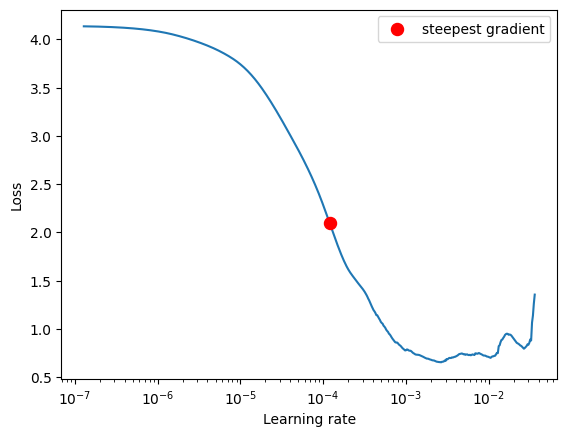

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model1_concat/lr_finder_plot.png
Suggested learning rate: 0.00011914805480891197


In [54]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1_concat", train_loader, val_loader, num_iter=num_epochs)

In [61]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1_concat", min_lr=2e-6, max_lr=2e-3)  # Train and evaluate Model1

Successfully created and tested Model1
0.002
1000.0000000000001

Training completed in 474.01 seconds
Best model found at epoch 99/100
Best Train Loss: 0.2317, Best Val Loss: 0.2435
Best Train MSE: 0.2317, Best Val MSE: 0.2442
Best Train RMSE: 0.4814, Best Val RMSE: 0.4942
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model1_concat/best_model.pth


Successfully created and tested Model2


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.42E-04


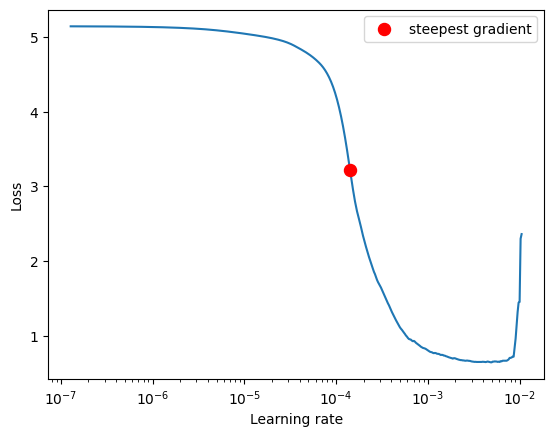

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model2_gating/lr_finder_plot.png
Suggested learning rate: 0.00014196258964747487


In [55]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2_gating", train_loader, val_loader, num_iter=num_epochs)

In [62]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2_gating", min_lr=2e-5, max_lr=3e-3)  # Train and evaluate Model2


Successfully created and tested Model2
0.003
150.0

Training completed in 499.39 seconds
Best model found at epoch 99/100
Best Train Loss: 0.2596, Best Val Loss: 0.2719
Best Train MSE: 0.2596, Best Val MSE: 0.2728
Best Train RMSE: 0.5095, Best Val RMSE: 0.5223
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model2_gating/best_model.pth


Successfully created and tested Model3


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.13E-04


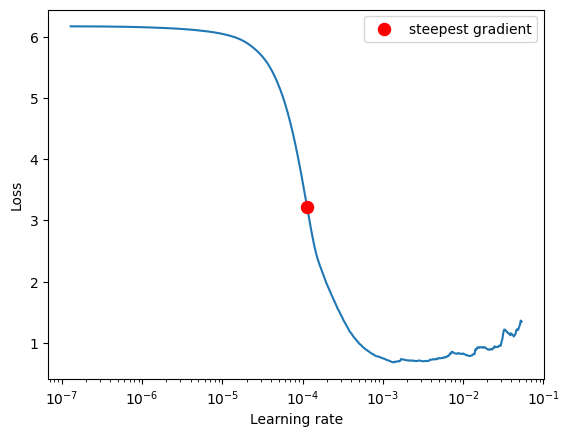

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model3_attention/lr_finder_plot.png
Suggested learning rate: 0.00011333076650185259


In [56]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3_attention", train_loader, val_loader, num_iter=num_epochs)

In [63]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3_attention", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model3
0.001
100.0

Training completed in 516.75 seconds
Best model found at epoch 97/100
Best Train Loss: 0.2281, Best Val Loss: 0.2455
Best Train MSE: 0.2281, Best Val MSE: 0.2458
Best Train RMSE: 0.4776, Best Val RMSE: 0.4958
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model3_attention/best_model.pth


Successfully created and tested Model4


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.61E-04


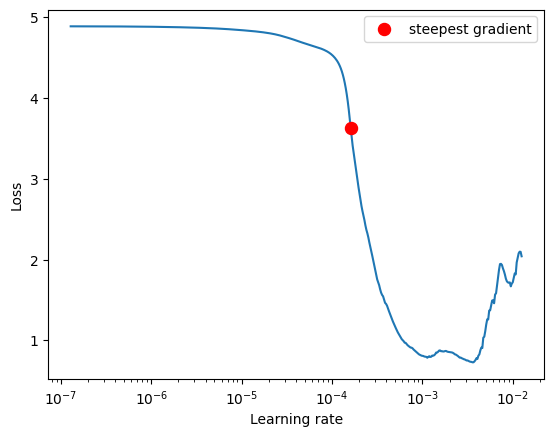

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model4_multihead_mean/lr_finder_plot.png
Suggested learning rate: 0.00016088729099336284


In [57]:
lr = run_lr_finder(Model4, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model4_multihead_mean", train_loader, val_loader, num_iter=num_epochs)

In [64]:
# Create and train Model4
model4 = try_create_model(Model4, patch_size, attributes, imgs_shape)  # Attempt to create Model4
model4_metrics = safe_compile_and_fit(model4, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model4_multihead_mean", min_lr=2e-5, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model4
0.002
100.0

Training completed in 538.33 seconds
Best model found at epoch 99/100
Best Train Loss: 0.2221, Best Val Loss: 0.2432
Best Train MSE: 0.2221, Best Val MSE: 0.2437
Best Train RMSE: 0.4713, Best Val RMSE: 0.4937
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model4_multihead_mean/best_model.pth


Successfully created and tested Model5


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.98E-05


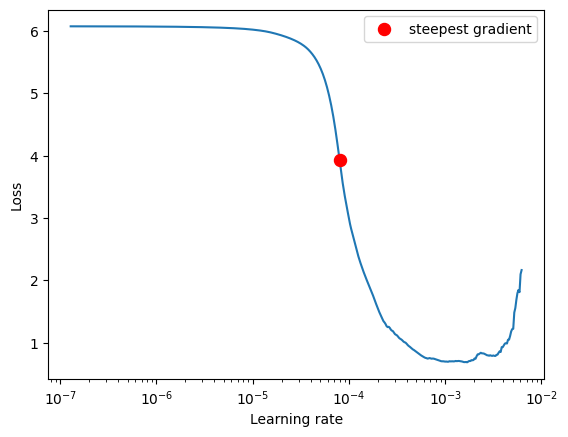

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model5_multihead_cls/lr_finder_plot.png
Suggested learning rate: 7.98314307898147e-05


In [58]:
lr = run_lr_finder(Model5, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model5_multihead_cls", train_loader, val_loader, num_iter=num_epochs)

In [65]:
# Create and train Model5
model5 = try_create_model(Model5, patch_size, attributes, imgs_shape)  # Attempt to create Model5
model5_metrics = safe_compile_and_fit(model5, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model5_multihead_cls", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model5
0.001
100.0

Training completed in 547.32 seconds
Best model found at epoch 91/100
Best Train Loss: 0.2364, Best Val Loss: 0.2568
Best Train MSE: 0.2364, Best Val MSE: 0.2570
Best Train RMSE: 0.4862, Best Val RMSE: 0.5070
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model5_multihead_cls/best_model.pth


Successfully created and tested Model6


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.51E-05


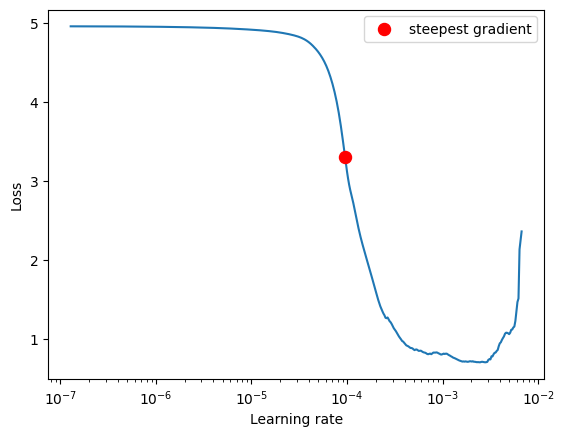

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model6_multihead_cls/lr_finder_plot.png
Suggested learning rate: 9.51175969121871e-05


In [59]:
lr = run_lr_finder(Model6, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model6_multihead_cls", train_loader, val_loader, num_iter=num_epochs)

In [66]:
# Create and train Model6
model6 = try_create_model(Model6, patch_size, attributes, imgs_shape)  # Attempt to create Model6
model6_metrics = safe_compile_and_fit(model6, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model6_multihead_cls", min_lr=2e-5, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model6
0.002
100.0

Training completed in 545.56 seconds
Best model found at epoch 99/100
Best Train Loss: 0.2693, Best Val Loss: 0.2834
Best Train MSE: 0.2693, Best Val MSE: 0.2841
Best Train RMSE: 0.5189, Best Val RMSE: 0.5330
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model6_multihead_cls/best_model.pth


Successfully created and tested Model7


  0%|          | 0/645 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.03E-04


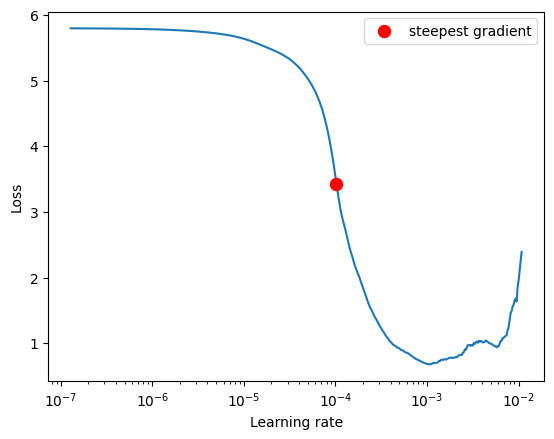

Plot saved to: logs/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model7_crossattention_cls/lr_finder_plot.png
Suggested learning rate: 0.0001025343931091533


In [60]:
lr = run_lr_finder(Model7, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model7_crossattention_cls", train_loader, val_loader, num_iter=num_epochs)

In [67]:
# Create and train Model7
model7 = try_create_model(Model7, patch_size, attributes, imgs_shape)  # Attempt to create Model7
model7_metrics = safe_compile_and_fit(model7, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model7_crossattention_cls", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model7
0.001
100.0

Training completed in 548.22 seconds
Best model found at epoch 94/100
Best Train Loss: 0.2814, Best Val Loss: 0.3456
Best Train MSE: 0.2814, Best Val MSE: 0.3465
Best Train RMSE: 0.5305, Best Val RMSE: 0.5886
Best model saved to models/Regression/california_housing/ViT+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model7_crossattention_cls/best_model.pth


In [68]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available
if model4_metrics:
    print("Model 4 Metrics:", model4_metrics)  # Print metrics for Model4 if available
if model5_metrics:
    print("Model 5 Metrics:", model5_metrics)  # Print metrics for Model5 if available
if model6_metrics:
    print("Model 6 Metrics:", model6_metrics)  # Print metrics for Model6 if available
if model7_metrics:
    print("Model 7 Metrics:", model7_metrics)  # Print metrics for Model7 if available

Model 1 Metrics: {'train_loss': 0.23148036985694206, 'train_mse': 0.23148037, 'train_mae': 0.32349807, 'train_rmse': 0.48112407, 'train_r2': 0.8255102634429932, 'val_loss': 0.24354862708311814, 'val_mse': 0.24421643, 'val_mae': 0.3279377, 'val_rmse': 0.4941826, 'val_r2': 0.8122257590293884, 'test_loss': 0.23772111030725332, 'test_mse': 0.23871894, 'test_mae': 0.33265617, 'test_rmse': 0.48858872, 'test_r2': 0.8296006917953491, 'min_lr': 2e-06, 'max_lr': 0.002, 'total_time': 474.0059278011322, 'average_epoch_time': 4.7400558876991274}
Model 2 Metrics: {'train_loss': 0.2587700084342744, 'train_mse': 0.25877002, 'train_mae': 0.34602454, 'train_rmse': 0.5086944, 'train_r2': 0.804939329624176, 'val_loss': 0.27187034785747527, 'val_mse': 0.27275673, 'val_mae': 0.3529573, 'val_rmse': 0.52226114, 'val_r2': 0.7902815341949463, 'test_loss': 0.2555595943560967, 'test_mse': 0.25696978, 'test_mae': 0.3498344, 'test_rmse': 0.5069219, 'test_r2': 0.8165731430053711, 'min_lr': 2e-05, 'max_lr': 0.003, 't

In [ ]:
#Select the model and the parameters
problem_type = "regression"
name = f"IGTD_{image_size*2}x{image_size*2}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-3, max_lr=1e-1)  # Train and evaluate Model2

In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-5, max_lr=1.5e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=4, random_seed=SEED)
name = f"IGTD_{image_size*4}x{image_size*4}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-4, max_lr=1e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-3, max_lr=8e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 3: REFINED

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, random_seed=SEED)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 2

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1X", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2X", min_lr=5e-5, max_lr=6e-4)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3X", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3X", min_lr=5e-5, max_lr=5e-4)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=2, random_seed=SEED)
name = f"REFINED_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-2, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=2e-3, max_lr=2e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=8e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=4, random_seed=SEED)
name = f"REFINED_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-2, max_lr=4e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=2e-3, max_lr=2e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=4e-3, max_lr=8e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 4: BAR GRAPH

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type)
name = f"BarGraph"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 13

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=3e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-3, max_lr=5e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-6, max_lr=3e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=2)
name = f"BarGraph_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
### Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=6e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=3e-3, max_lr=6e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=4)
name = f"BarGraph_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=3e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=2e-3, max_lr=1e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-6, max_lr=3e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 5: DISTANCE MATRIX

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type)
name = f"DistanceMatrix"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 13

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-3, max_lr=2e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-5, max_lr=2e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=2)
name = f"DistanceMatrix_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=5e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-3, max_lr=8e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=4)
name = f"DistanceMatrix_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=9e-3, max_lr=4e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 6: COMBINATION

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type)
name = f"Combination"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 13

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=2e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=2)
name = f"Combination_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-4, max_lr=1.5e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-3, max_lr=8e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)
name = f"Combination_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-3,max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=3e-3, max_lr=1e-1)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-3, max_lr=8e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 7: SUPERTML

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, random_seed=SEED)
name = f"SuperTML-EF"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 16

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=3e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-4, max_lr=3e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=6e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=30, random_seed=SEED)
name = f"SuperTML-VF_FS30"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 16

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=4e-2)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=9e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-6, max_lr=3e-3)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

### EXPERIMENT 8: FEATURE WRAP

In [ ]:
#Select the model and the parameters
problem_type = "regression"
image_model = FeatureWrap(problem = problem_type)
name = f"FeatureWrap"

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [ ]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

In [ ]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

In [ ]:
patch_size = 4

In [ ]:
lr = run_lr_finder(Model1, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs*3)

In [ ]:
# Create and train Model1
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=3e-3, max_lr=2e-1)  # Train and evaluate Model1

In [ ]:
lr = run_lr_finder(Model2, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs*3)

In [ ]:
# Create and train Model2
model2 = try_create_model(Model2, patch_size, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=2e-2)  # Train and evaluate Model2


In [ ]:
lr = run_lr_finder(Model3, patch_size, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs*3)

In [ ]:
# Create and train Model3
model3 = try_create_model(Model3, patch_size, attributes, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-2)  # Train and evaluate Model3

In [ ]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

## FINAL METRICS AND BEST MODEL

In [ ]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [ ]:
import os

def read_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split(': ')
            metrics[key.strip()] = float(value.strip())
    return metrics

def rename_folder(old_folder_path, prefix):
    folder_name = os.path.basename(old_folder_path)
    new_folder_name = f"{prefix}_{folder_name}"
    parent_dir = os.path.dirname(old_folder_path)
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    os.rename(old_folder_path, new_folder_path)
    return new_folder_path

def process_folders(root_dir):
    prefixes = ["TINTO", "BarGraph", "Combination", "DistanceMatrix", "IGTD", "REFINED", "SuperTML", "FeatureWrap"]
    best_folders = []

    for prefix in prefixes:
        matching_folders = [f for f in os.listdir(root_dir) if f.startswith(prefix) and os.path.isdir(os.path.join(root_dir, f))]
        if matching_folders:
            best_folder = None
            best_test_rmse = float('inf')
            for folder in matching_folders:
                metrics_file = os.path.join(root_dir, folder, 'metrics.txt')
                if os.path.exists(metrics_file):
                    metrics = read_metrics(metrics_file)
                    if metrics['test_rmse'] < best_test_rmse:
                        best_test_rmse = metrics['test_rmse']
                        best_folder = folder
            if best_folder:
                new_path = rename_folder(os.path.join(root_dir, best_folder), "TOP")
                best_folders.append(new_path)
    
    if best_folders:
        overall_best_folder = None
        overall_best_test_rmse = float('inf')
        for folder in best_folders:
            metrics_file = os.path.join(folder, 'metrics.txt')
            if os.path.exists(metrics_file):
                metrics = read_metrics(metrics_file)
                if metrics['test_rmse'] < overall_best_test_rmse:
                    overall_best_test_rmse = metrics['test_rmse']
                    overall_best_folder = folder
        if overall_best_folder:
            rename_folder(overall_best_folder, "BEST")
        
    return best_folders

In [ ]:
# Usage
base_path = f"logs/Regression/{dataset_name}/ViT+MLP/"
best_folders = process_folders(base_path)
print(f"Best model folder: {best_folders}")